In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random
from tqdm import tqdm

from matplotlib import pyplot as plt


In [5]:
from iterative_sir.toy_examples_utils import prepare_25gaussian_data
from iterative_sir.sampling_utils.adaptive_mc import adaptive_sir_correlated_dynamics, ex2_mcmc_mala
from iterative_sir.sampling_utils.sir_ais_sampling import sir_correlated_dynamics
from iterative_sir.sampling_utils.adaptive_sir_loss import *

from iterative_sir.sampling_utils.flows import RNVP


from iterative_sir.sampling_utils.distributions import (Distribution, 
                           GaussianMixture, 
                           IndependentNormal,
                           init_independent_normal)

from iterative_sir.toy_examples_utils.params_25gaussians import (sigma,
                                random_seed,
                                train_dataset_size,
                                n_dim,
                                device)


In [4]:
from pathlib import Path
figpath = Path('../figs')

# 2D Gaussians, true distribution

In [5]:
from sklearn.preprocessing import StandardScaler

# torch.manual_seed(random_seed)
# np.random.seed(random_seed)
# random.seed(random_seed)

X_train, means = prepare_25gaussian_data(train_dataset_size,
                                         sigma, 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [6]:
n_dim = 5
target_args = edict()
target_args.device = device
target_args.num_gauss = 25
n_col = 5
n_row = target_args.num_gauss // n_col
s = 1
###create points
coef_gaussian = 1./target_args.num_gauss
target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
locs = [torch.tensor([(i-2)*s,(j-2)*s] + [0]* (n_dim - 2)).to(device) 
        for i in range(n_col) for j in range(n_row)]
target_args.locs = locs
target_args.covs = [(sigma**2)*torch.eye(n_dim).to(device)]*target_args.num_gauss
target_args.dim = n_dim
true_target = Gaussian_mixture(target_args).log_prob


loc_proposal = torch.zeros(n_dim).to(device)
scale_proposal = 0.5 * torch.ones(n_dim).to(device) #3*torch.ones(n_dim).to(device)
proposal_args = edict()
proposal_args.device = device
proposal_args.loc = loc_proposal
proposal_args.scale = scale_proposal
proposal = IndependentNormal(proposal_args)

In [7]:
evols = dict()

In [8]:
true_target_energy = Gaussian_mixture(target_args).energy

x_range = 3.0
y_range = 3.0
norm_grads = False

In [9]:
batch_size = 100
lr = 1e-3
N_optim = 1000
start_optim = 10
n_steps = 1
num_flows = 4

In [10]:
loss = "mix_kl"  #"backward_kl" #"mix_kl" 
loss_function = get_loss(loss)
flow = RNVP(num_flows=num_flows, dim = n_dim)
optimizer = get_optimizer(flow.parameters(), optimizer = "Adam", lr=lr, weight_decay=1e-4)

z_0 = proposal.sample((batch_size,))

# N_optim = 100
alpha = 0.  #0.1
# n_steps = 10
N = 10

#n_total = 100
resample_every = 10

z_ = z_0.clone()
do_refresh = False #True

sample = []

for i in tqdm(range(N_optim)):
    if i == 0:
        z_0 = proposal.sample((batch_size,))
        z_ = z_0
    elif do_refresh:
        # refresh
        p = 0.5 #1.0 #0.1 #1.0
        sz = np.random.binomial(batch_size, p, 1)[0]
        z_0 = proposal.sample((sz,))
        if batch_size - sz > 0:
            ids = np.random.choice(np.arange(batch_size), batch_size - sz)
            old = zl[-1][ids] #.detach()
            inv_old, _ = flow.inverse(old)
            z_ = torch.cat([z_0, inv_old], 0)
        else:
            z_ = z_0
    else:
        z_ = zl[-1] #.detach()
        z_, _ = flow.inverse(z_)

    # if i % resample_every:
    #     #z_0 = proposal.sample((batch_size,))
    #     z_, _ = flow.inverse(z_)
    #     zl = adaptive_sir_correlated_dynamics(z_, true_target, proposal, n_steps, N, 0., flow)
    # else:
    #     zl = sir_correlated_dynamics(z_, true_target, proposal, n_steps, N, alpha) #, None)
    
    zl = adaptive_sir_correlated_dynamics(z_, true_target, proposal, n_steps, N, alpha, flow)

    z_ = zl[-1]
    loss, grad_loss = loss_function(true_target, proposal, flow, z_)
    sample.append(z_.detach().numpy())

    if i%100 == 0:
        print(f'{loss.item():.3f}, {grad_loss:.3f}')

    if i > start_optim:
        optimizer.zero_grad()
        grad_loss.backward()
        optimizer.step()
sample = np.array(sample).reshape(-1,n_dim)

  0%|          | 2/1000 [00:00<02:20,  7.12it/s]

-52.452, 6.814


 10%|█         | 101/1000 [00:14<02:58,  5.03it/s]

3.139, 3.756


 20%|██        | 202/1000 [00:25<01:28,  8.98it/s]

5.131, 2.484


 30%|███       | 302/1000 [00:36<01:24,  8.23it/s]

5.232, 1.514


 40%|████      | 402/1000 [00:46<01:20,  7.39it/s]

5.536, 1.502


 50%|█████     | 501/1000 [00:58<01:08,  7.33it/s]

5.567, 1.288


 60%|██████    | 603/1000 [01:09<00:29, 13.40it/s]

5.756, 1.529


 70%|███████   | 704/1000 [01:13<00:13, 22.74it/s]

5.832, 1.613


 80%|████████  | 803/1000 [01:18<00:08, 24.57it/s]

5.944, 1.836


 90%|█████████ | 903/1000 [01:22<00:04, 22.36it/s]

5.878, 1.683


100%|██████████| 1000/1000 [01:26<00:00, 11.51it/s]


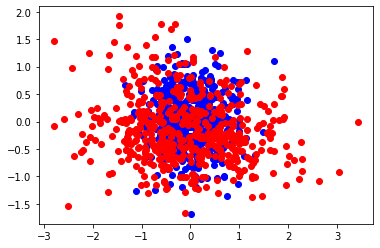

In [11]:
z_0 = proposal.sample((500,))
out, _ = flow(z_0)

out = out.detach()

plt.scatter(z_0[:, 0], z_0[:, 1], c='b')
plt.scatter(out[:, 0], out[:, 1], c='r')

In [12]:
def plot_sample(sample, name=None):
    plt.figure()
    plt.xlim(-3., 3.)
    plt.ylim(-3., 3.)
    if name is not None:
        plt.title(f"Training and Adapt_MC_NF samples", fontsize=20)
    plt.scatter(sample[-5000:,0], sample[-5000:,1], alpha=0.3, color='gray', 
                marker='o') #, label = 'training samples')
    label = 'Adapt_MC_NF samples'

    #plt.scatter(fake[:,:1], fake[:,1:], alpha=0.3, color='blue', 
    #            marker='o', label = label)
    plt.legend()
    plt.grid(True)
    plt.show()

No handles with labels found to put in legend.


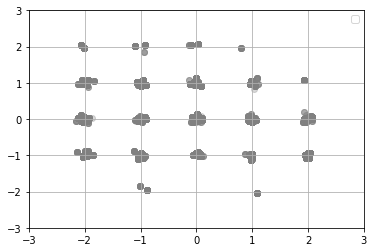

In [13]:
plot_sample(sample)

In [14]:
alpha = 0.9

z_ = proposal.sample((batch_size,))
zl = adaptive_sir_correlated_dynamics(z_, true_target, proposal, 1000, N, alpha, flow)
sample = np.array([_.detach().numpy() for _ in zl]).reshape(-1, n_dim)

No handles with labels found to put in legend.


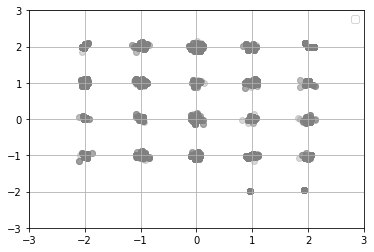

In [15]:
plot_sample(sample)

In [16]:
#from iterative_sir.sampling_utils.adaptive_mc import ex2_mcmc_mala_temp
flow = RNVP(num_flows=num_flows, dim = n_dim)
loss = "mix_kl"  #"backward_kl" #"mix_kl" 
loss_function = get_loss(loss)
optimizer = get_optimizer(flow.parameters(), optimizer = "Adam", lr=lr, weight_decay=1e-4)

# N_optim = 100
# n_steps = 10
N = 10

grad_step = 1e-2
noise_scale = (2 * grad_step)**.5
corr_coef = 0.0
bernoulli_prob_corr = 0.0 #0.5

do_refresh = False 

sample = []

for i in tqdm(range(N_optim)):
    if i == 0:
        z_0 = proposal.sample((batch_size,))
        z_ = z_0
    elif do_refresh:
        # refresh
        p = 0.9 
        sz = np.random.binomial(batch_size, p, 1)[0]
        z_0 = proposal.sample((sz,))
        if batch_size - sz > 0:
            ids = np.random.choice(np.arange(batch_size), batch_size - sz)
            old = zl[-1][ids] #.detach()
            inv_old, _ = flow.inverse(old)
            z_ = torch.cat([z_0, inv_old], 0)
        else:
            z_ = z_0
    else:
        z_ = zl[-1] #.detach()
        z_, _ = flow.inverse(z_)
    
    out = ex2_mcmc_mala(z_, true_target, proposal, n_steps, N, 
                        grad_step=grad_step, noise_scale=noise_scale, 
                        corr_coef=corr_coef, bernoulli_prob_corr=bernoulli_prob_corr, flow=flow, adapt_stepsize=True, mala_steps=0) #1)
    zl = out[0]
    grad_step = out[-1]
    noise_scale = (2 * grad_step)**.5
    acc_rate = out[1]
    z_ = zl[-1]

    sample.append(z_.detach().numpy())
    loss, grad_loss = loss_function(true_target, proposal, flow, z_)
    if i%25 == 0:
       print(f'{loss.item():.3f}, {grad_loss.item():.3f}, {acc_rate.mean():.3f}')
    
    if i > start_optim:
        optimizer.zero_grad()
        grad_loss.backward()
        optimizer.step()
    
sample = np.concatenate(sample, 0)

  0%|          | 4/1000 [00:00<01:37, 10.25it/s]

-61.756, 4.973, 0.000


  3%|▎         | 29/1000 [00:01<00:58, 16.50it/s]

7.476, 4.828, 0.460


  5%|▌         | 53/1000 [00:03<01:03, 14.89it/s]

8.211, 3.497, 0.450


  8%|▊         | 79/1000 [00:04<00:53, 17.37it/s]

7.279, 2.610, 0.490


 10%|█         | 103/1000 [00:06<00:50, 17.69it/s]

6.044, 1.603, 0.530


 13%|█▎        | 129/1000 [00:07<00:49, 17.57it/s]

5.996, 1.394, 0.400


 15%|█▌        | 153/1000 [00:09<01:25,  9.95it/s]

5.464, 1.047, 0.420


 18%|█▊        | 176/1000 [00:12<01:05, 12.58it/s]

5.402, 0.749, 0.520


 20%|██        | 200/1000 [00:14<01:20,  9.96it/s]

4.992, 0.571, 0.480


 23%|██▎       | 227/1000 [00:20<01:33,  8.23it/s]

5.261, 0.562, 0.390


 25%|██▌       | 253/1000 [00:24<01:42,  7.28it/s]

5.093, 0.409, 0.460


 28%|██▊       | 276/1000 [00:27<01:20,  8.95it/s]

4.787, 0.295, 0.470


 30%|███       | 301/1000 [00:31<02:47,  4.17it/s]

5.191, 0.474, 0.510


 33%|███▎      | 327/1000 [00:36<01:45,  6.40it/s]

4.953, 0.504, 0.420


 35%|███▌      | 352/1000 [00:39<01:31,  7.10it/s]

5.494, 0.652, 0.350


 38%|███▊      | 377/1000 [00:43<01:28,  7.04it/s]

5.425, 0.672, 0.480


 40%|████      | 402/1000 [00:46<01:26,  6.94it/s]

5.848, 1.225, 0.460


 43%|████▎     | 427/1000 [00:50<01:22,  6.95it/s]

6.009, 1.406, 0.490


 45%|████▌     | 452/1000 [00:53<01:19,  6.91it/s]

5.622, 1.109, 0.410


 48%|████▊     | 477/1000 [00:57<01:12,  7.17it/s]

5.862, 1.157, 0.400


 50%|█████     | 502/1000 [01:01<01:04,  7.71it/s]

5.886, 1.391, 0.410


 53%|█████▎    | 527/1000 [01:04<01:14,  6.38it/s]

5.897, 1.363, 0.490


 55%|█████▌    | 552/1000 [01:09<00:49,  9.10it/s]

6.108, 1.596, 0.420


 58%|█████▊    | 577/1000 [01:12<00:59,  7.05it/s]

5.954, 1.525, 0.480


 60%|██████    | 602/1000 [01:15<00:52,  7.63it/s]

5.999, 1.255, 0.440


 63%|██████▎   | 626/1000 [01:20<01:10,  5.31it/s]

6.084, 1.495, 0.420


 65%|██████▌   | 651/1000 [01:26<01:15,  4.63it/s]

6.129, 1.451, 0.470


 68%|██████▊   | 677/1000 [01:30<00:50,  6.44it/s]

5.957, 1.545, 0.450


 70%|███████   | 702/1000 [01:35<01:10,  4.22it/s]

6.362, 1.702, 0.420


 73%|███████▎  | 727/1000 [01:40<00:49,  5.55it/s]

6.220, 1.579, 0.420


 75%|███████▌  | 751/1000 [01:45<00:56,  4.40it/s]

6.296, 1.768, 0.370


 78%|███████▊  | 777/1000 [01:50<00:37,  5.89it/s]

6.479, 1.842, 0.410


 80%|████████  | 801/1000 [01:54<00:37,  5.25it/s]

6.213, 1.605, 0.600


 83%|████████▎ | 826/1000 [01:59<00:35,  4.89it/s]

6.199, 1.531, 0.510


 85%|████████▌ | 852/1000 [02:03<00:21,  7.02it/s]

6.274, 1.534, 0.470


 88%|████████▊ | 877/1000 [02:07<00:23,  5.22it/s]

6.290, 1.752, 0.450


 90%|█████████ | 902/1000 [02:12<00:13,  7.43it/s]

6.171, 1.731, 0.410


 93%|█████████▎| 927/1000 [02:15<00:09,  7.96it/s]

6.166, 1.606, 0.500


 95%|█████████▌| 952/1000 [02:18<00:05,  8.77it/s]

6.250, 1.795, 0.470


 98%|█████████▊| 977/1000 [02:21<00:02,  8.06it/s]

5.913, 1.389, 0.430


100%|██████████| 1000/1000 [02:24<00:00,  6.90it/s]


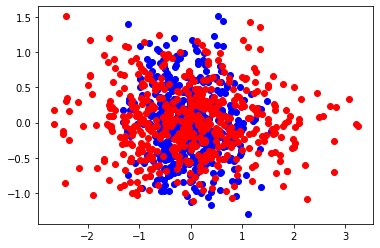

In [17]:
z_0 = proposal.sample((500,))
out, _ = flow(z_0)

out = out.detach()

plt.scatter(z_0[:, 0], z_0[:, 1], c='b')
plt.scatter(out[:, 0], out[:, 1], c='r')

No handles with labels found to put in legend.


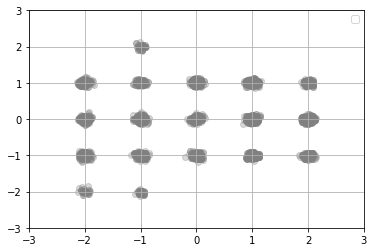

In [18]:
plot_sample(sample)

In [19]:
corr_coef = 0.5
bernoulli_prob_corr = 0.5

z_ = proposal.sample((1,))
out = ex2_mcmc_mala(z_, true_target, proposal, 1000, N, 
                        grad_step=grad_step, noise_scale=noise_scale, 
                        corr_coef=corr_coef, bernoulli_prob_corr=bernoulli_prob_corr, flow=flow, adapt_stepsize=True, verbose=True, mala_steps=1)
zl = out[0]
zl = zl[-1000:]
sample = np.array([_.detach().numpy() for _ in zl]).reshape(-1, n_dim)

100%|██████████| 1000/1000 [00:44<00:00, 22.32it/s]


No handles with labels found to put in legend.


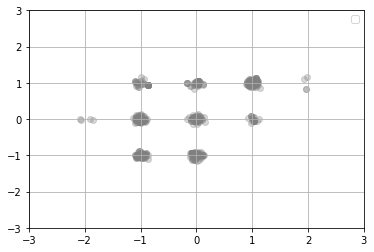

In [20]:
plot_sample(sample)

In [21]:
N

10